## 1. Packages & Parallel Processing Setup

In [ ]:
using Distributed
if nworkers() == 1
    addprocs(10) # PARAM - adjust number of workers as needed i.e. available CPU cores
nworkers()
using Plots
using ProgressMeter
@everywhere using Agents, Statistics, Random

In [14]:
########### Building the Model ###########

## 2. Agent definition

In [ ]:
@everywhere @agent struct SchellingAgent(GridAgent{2}) # Agent on a 2D grid (adapted from Agents.jl)
    mood::Bool
    group::Int
end

## 3. Model initialization 

In [16]:
@everywhere function initialize(; M::Int=10,
    min_to_be_happy::Float64=0.5,
    ρ::Float64=0.9,
    proportion_red::Float64=0.5,
    lonely_agents_unhappy::Bool=true)
    gridsize = (M, M)
    space = GridSpaceSingle(gridsize; periodic=true, metric=:chebyshev)
    total_agents = round(Int, ρ * prod(gridsize))

    properties = Dict(
        :min_to_be_happy => min_to_be_happy,
        :M => M,
        :ρ => ρ,
        :total_agents => total_agents,
        :lonely_agents_unhappy => lonely_agents_unhappy
    )

    model = StandardABM(
        SchellingAgent, space;
        agent_step!,
        properties=properties,
        scheduler=Schedulers.Randomly()
    )

    for _ in 1:total_agents
        add_agent_single!(
            model;
            mood=false,
            group=rand() < proportion_red ? 1 : 2
        )
    end

    return model
end


## 4. Dynamics - agent_step! 

In [ ]:
# # Define the stepping function for each agent
@everywhere function agent_step!(agent, model)
    minhappy = model.min_to_be_happy
    nbrs = collect(nearby_agents(agent, model)) # Get all neighboring agents

    # Handle case where agent has no neighbors
    if isempty(nbrs)
        if model.lonely_agents_unhappy
            agent.mood = false               # Lonely agents are unhappy
            move_agent_single!(agent, model) # Move to a random empty cell
        else
            agent.mood = true                # Lonely agents are content
        end
        return
    end

    # Calculate fraction of neighbors that are same group
    same = count(n -> n.group == agent.group, nbrs)
    frac = same / length(nbrs)


    if frac ≥ minhappy                   # Update mood and move if unhappy
        agent.mood = true                # Agent is happy with neighbors
    else
        agent.mood = false               # Agent is unhappy
        move_agent_single!(agent, model) # Move to random empty cell
    end
end


In [18]:
########### Simulation and Data Collection ###########

## 5. Helper - measurement



In [19]:
# Calculate the average similarity across all agents with neighbors
@everywhere function calculate_average_similarity(model)
    sims = Float64[]
    for a in allagents(model)
        nbrs = collect(nearby_agents(a, model)) # Get neighbors
        if isempty(nbrs)
            push!(sims, 1.0)
        else
            same = count(n -> n.group == a.group, nbrs) # Count similar neighbors
            push!(sims, same / length(nbrs))  # Add fraction of similar neighbors
        end
    end
    return isempty(sims) ? 0.0 : mean(sims)  # Return mean similarity or 0 if no data
end

## 6. Helper - run single simulation 



In [20]:
# Function to run a single simulation with given parameters (for parallel execution)
@everywhere function run_single_simulation(params)
    density, threshold, M, steps, lonely = params
    model = initialize(
        M=M,
        min_to_be_happy=threshold,
        ρ=density,
        proportion_red=0.5,
        lonely_agents_unhappy=lonely
    )
    run!(model, steps)  # Run simulation for specified number of steps
    return calculate_average_similarity(model)  # Return final average similarity
end

## 7. Setup simulation (over parameter ranges) & build plots (not best practice to have plots in simulation loop but okay for lightweight application with moderate RAM)

In [ ]:
function simulate_and_plots_similarity(lonely_agents_unhappy::Bool=true)
    # Define parameter ranges 
    densities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.9] # Agent densities # PARAM
    thresholds = collect(0.1:0.05:0.9) # Similarity thresholds # PARAM
    runs_configs = [1, 5, 100] # Number of runs per configuration # PARAM
    M = 60 # Grid size # PARAM
    steps = 100 # Simulation steps # PARAM
    colors = [:red, :orange, :green, :lightgreen, :cyan, :blue, :purple]  # Colors for densities # PARAM
    plots = Vector{}()  # Store generated plots

    # Plots for each run configuration
    for runs in runs_configs
        println("Running simulations with $runs runs per combo…")
        all_results = Dict{}()  # Store results by density

        # Progress bar over the densities
        prog = Progress(length(densities);
            desc="densities @ $runs runs",
            barlen=30)

        # Run simulations for each density
        for (d_idx, density) in enumerate(densities)
            next!(prog)

            trial_matrix = zeros(runs, length(thresholds))  # Store results for all runs

            # Run simulations for each threshold
            for (t_idx, threshold) in enumerate(thresholds)
                # Create parameter tuples for parallel execution
                params = [(density, threshold, M, steps, lonely_agents_unhappy)
                          for r in 1:runs]
                sim_results = pmap(run_single_simulation, params)  # Run in parallel
                trial_matrix[:, t_idx] = sim_results
            end

            all_results[density] = trial_matrix
        end

        # Plot
        p = Plots.plot(
            title="$runs runs per combo",
            xlabel="similarity-threshold",
            ylabel="average similarity",
            legend=:bottom,
            legendtitle="density",
            xlim=(0.08, 0.92),
            ylim=(0.48, 1.02),
            size=(700, 550),
            left_margin=15Plots.mm,
            right_margin=15Plots.mm,
            top_margin=17Plots.mm,
            bottom_margin=15Plots.mm,
            dpi=300,
            framestyle=:box,
            grid=true,
            gridstyle=:dot,
            gridalpha=0.3,
            legendfontsize=9,
            titlefontsize=12,
            guidefontsize=11
        )

        # Add data to plot for each density
        for (i, density) in enumerate(densities)
            tm = all_results[density]
            means = vec(mean(tm, dims=1))  # Calculate mean across runs

            # Add scatter points for individual runs
            for (t_idx, threshold) in enumerate(thresholds)
                Plots.scatter!(
                    p,
                    fill(threshold, runs),
                    tm[:, t_idx];
                    label="",
                    markersize=2,
                    alpha=runs == 1 ? 0.8 : (runs == 5 ? 0.4 : 0.15),  # Adjust transparency
                    color=colors[i],
                    markerstrokewidth=0
                )
            end

            # Add mean line for density
            Plots.plot!(
                p,
                thresholds, means;
                label="$density",
                linewidth=2.5,
                linestyle=:solid,
                color=colors[i],
            )
        end

        push!(plots, p)
    end
    return plots
end

simulate_and_plots_similarity (generic function with 2 methods)

## 8. Helper - simulation & plotting

In [ ]:
function sim_both_lonely_versions_plots()
    plots_lonely = simulate_and_plots_similarity(true)   # Lonely agents are unhappy
    plots_non_lonely = simulate_and_plots_similarity(false)  # Lonely agents are content
    return plots_lonely, plots_non_lonely
end


sim_both_lonely_versions_plots (generic function with 1 method)

In [ ]:

# Makes side-by-side comparison plots
function create_comparison_plots()
    plots_lonely, plots_non_lonely = sim_both_lonely_versions_plots()
    runs_configs = [1, 5, 100]

    out = Plots.Plot[]

    # Compare plots for each configuration
    for (runs, pL, pN) in zip(runs_configs, plots_lonely, plots_non_lonely)
        runlabel = "$runs run$(runs == 1 ? "" : "s") per combo"

        # Remove titles 
        pL_clean = Plots.plot(pL, title="")
        pN_clean = Plots.plot(pN, title="")

        # Combined plot with two subplots
        fig = Plots.plot(
            pL_clean, pN_clean;
            layout=(1, 2),
            size=(1400, 600),
            left_margin=20Plots.mm,
            right_margin=20Plots.mm,
            top_margin=17Plots.mm,
            bottom_margin=20Plots.mm,
            plot_title=runlabel,   # Main title
            plot_titlefontsize=16,
            framestyle=:box,
            fmt=:png
        )

        # Add subplot titles
        Plots.annotate!(
            fig[1],
            0.5, 1.08,               # Position above subplot
            Plots.text("Lonely Loners", :center, 14, :black),
            subplot=1,
            transform=:relative    # Use relative coordinates
        )

        Plots.annotate!(
            fig[2],
            0.5, 1.08,
            Plots.text("Contented Loners", :center, 14, :black),
            subplot=2,
            transform=:relative
        )

        push!(out, fig)
    end

    return out
end

create_comparison_plots (generic function with 1 method)

## 9. Simulate & display plots


Running simulations with 1 runs per combo…


densities @ 1 runs 100%|██████████████████████████████| Time: 0:00:03


Running simulations with 5 runs per combo…


densities @ 5 runs 100%|██████████████████████████████| Time: 0:00:04


Running simulations with 100 runs per combo…


densities @ 100 runs 100%|██████████████████████████████| Time: 0:00:40


Running simulations with 1 runs per combo…


densities @ 1 runs 100%|██████████████████████████████| Time: 0:00:02


Running simulations with 5 runs per combo…


densities @ 5 runs 100%|██████████████████████████████| Time: 0:00:03


Running simulations with 100 runs per combo…


densities @ 100 runs 100%|██████████████████████████████| Time: 0:00:40


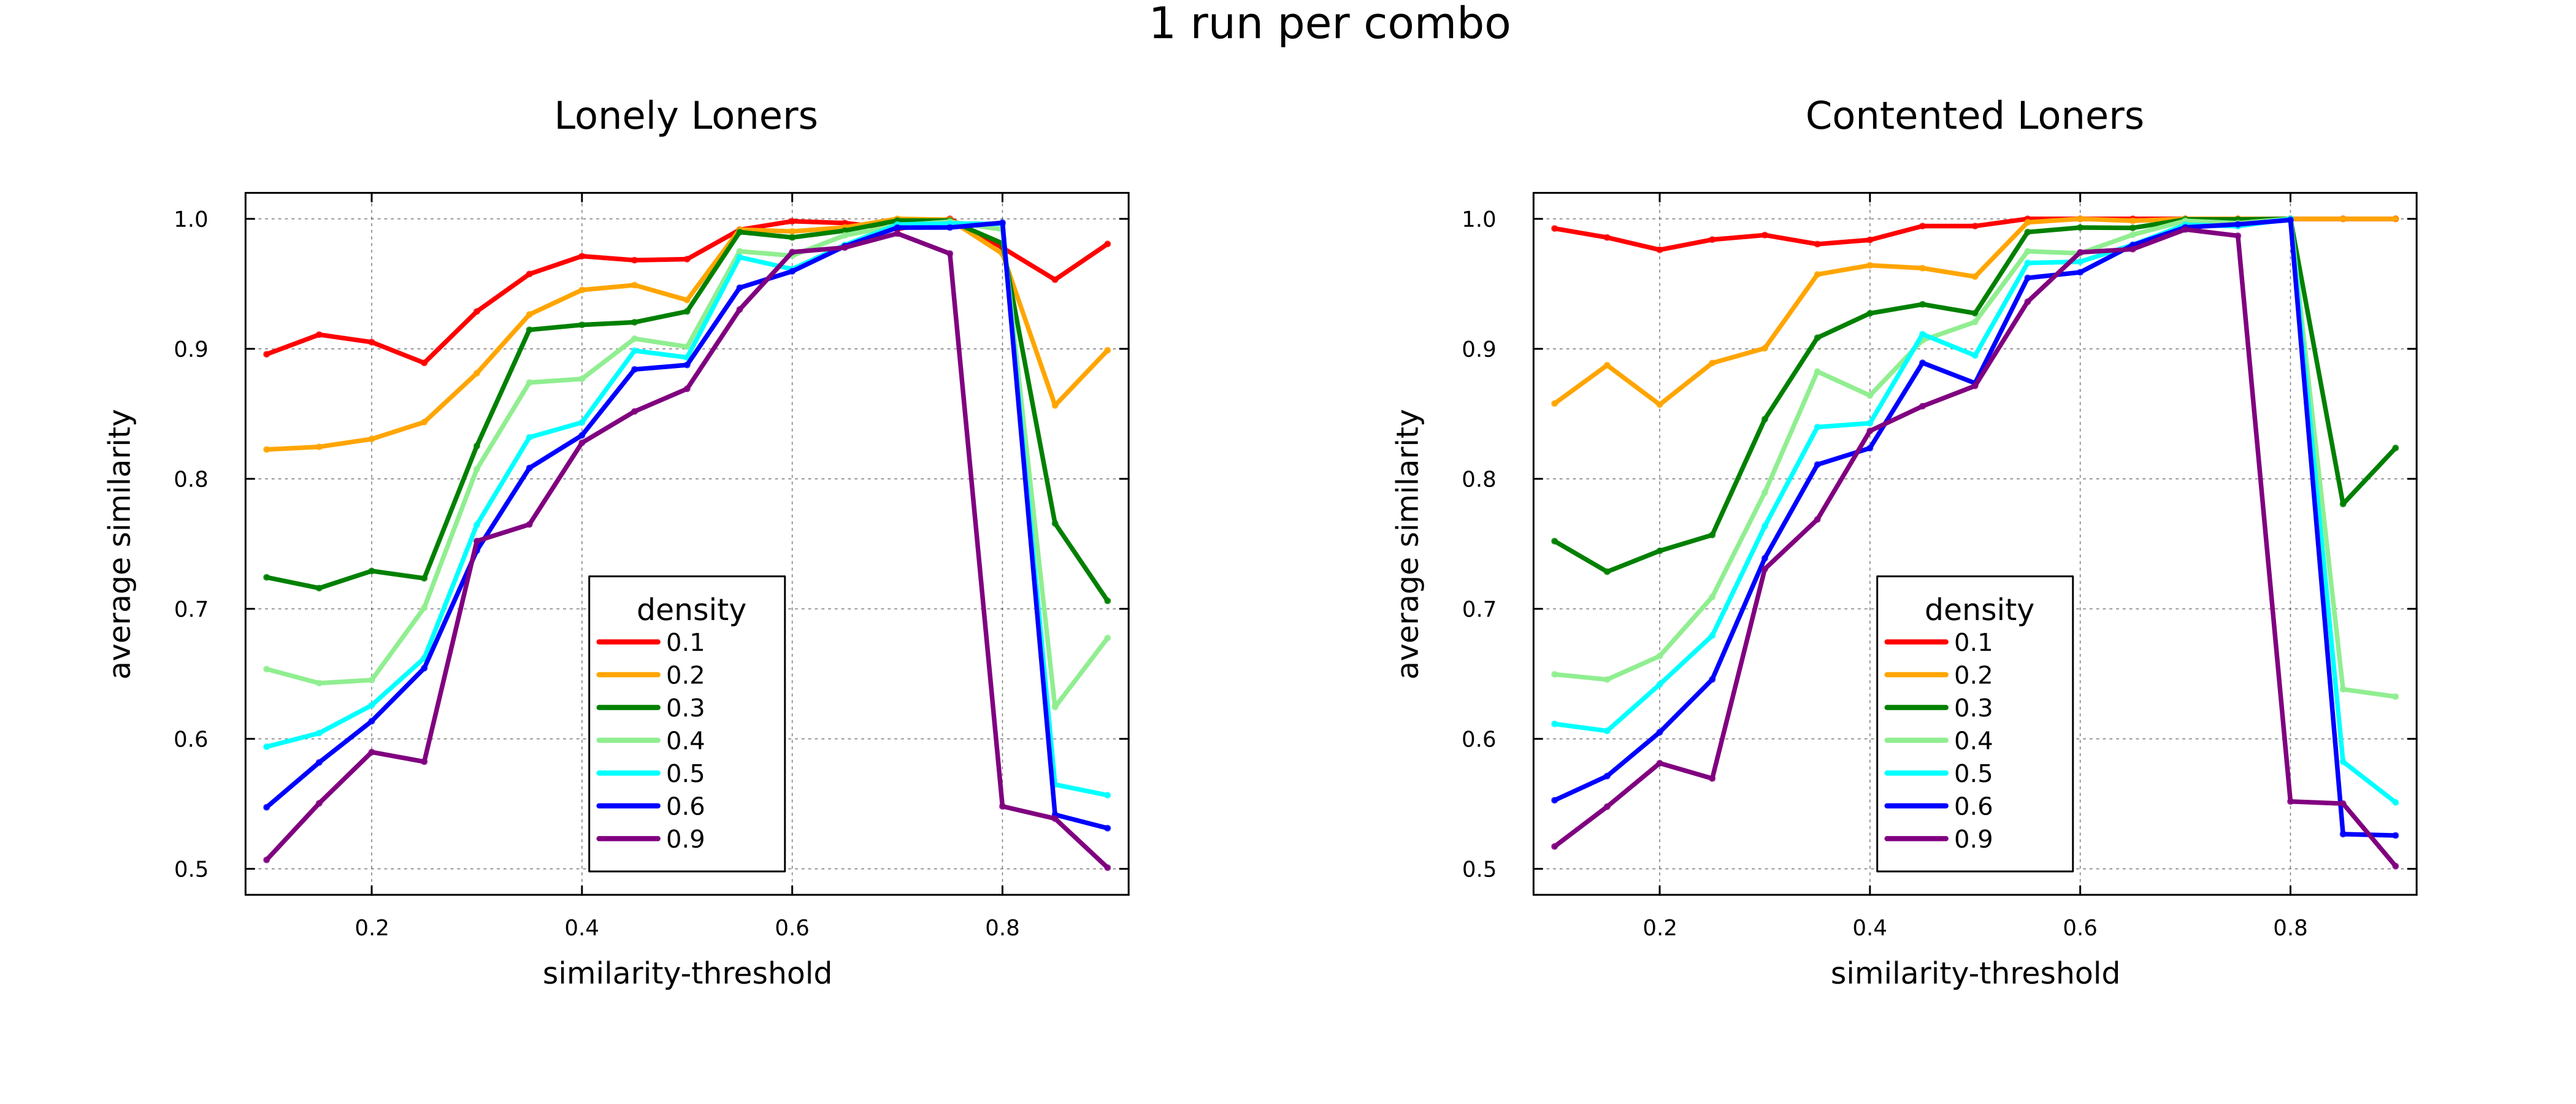

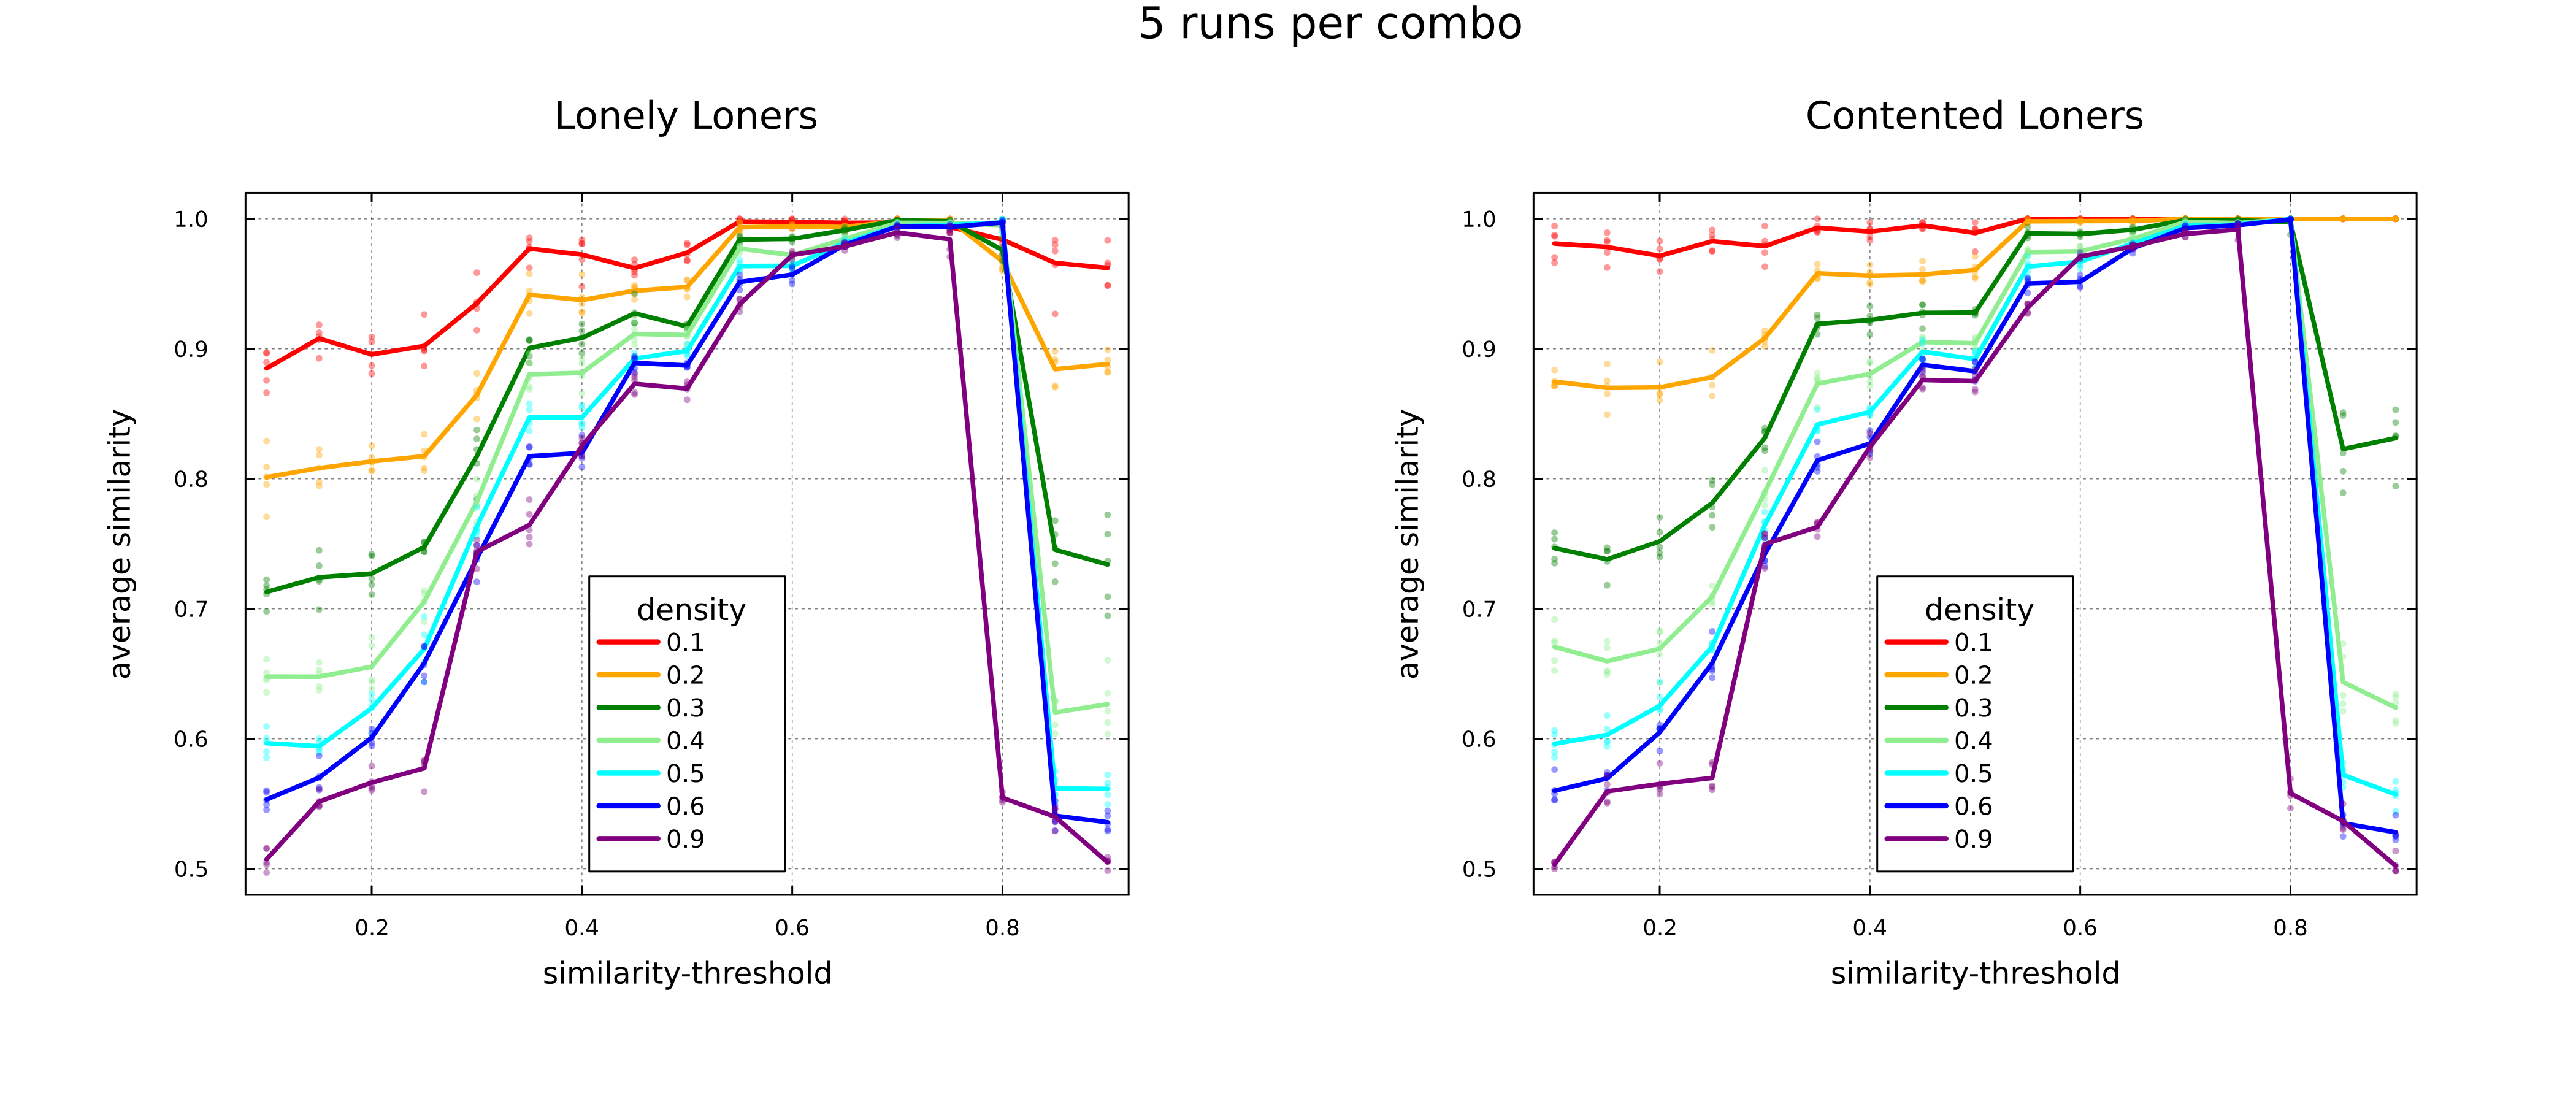

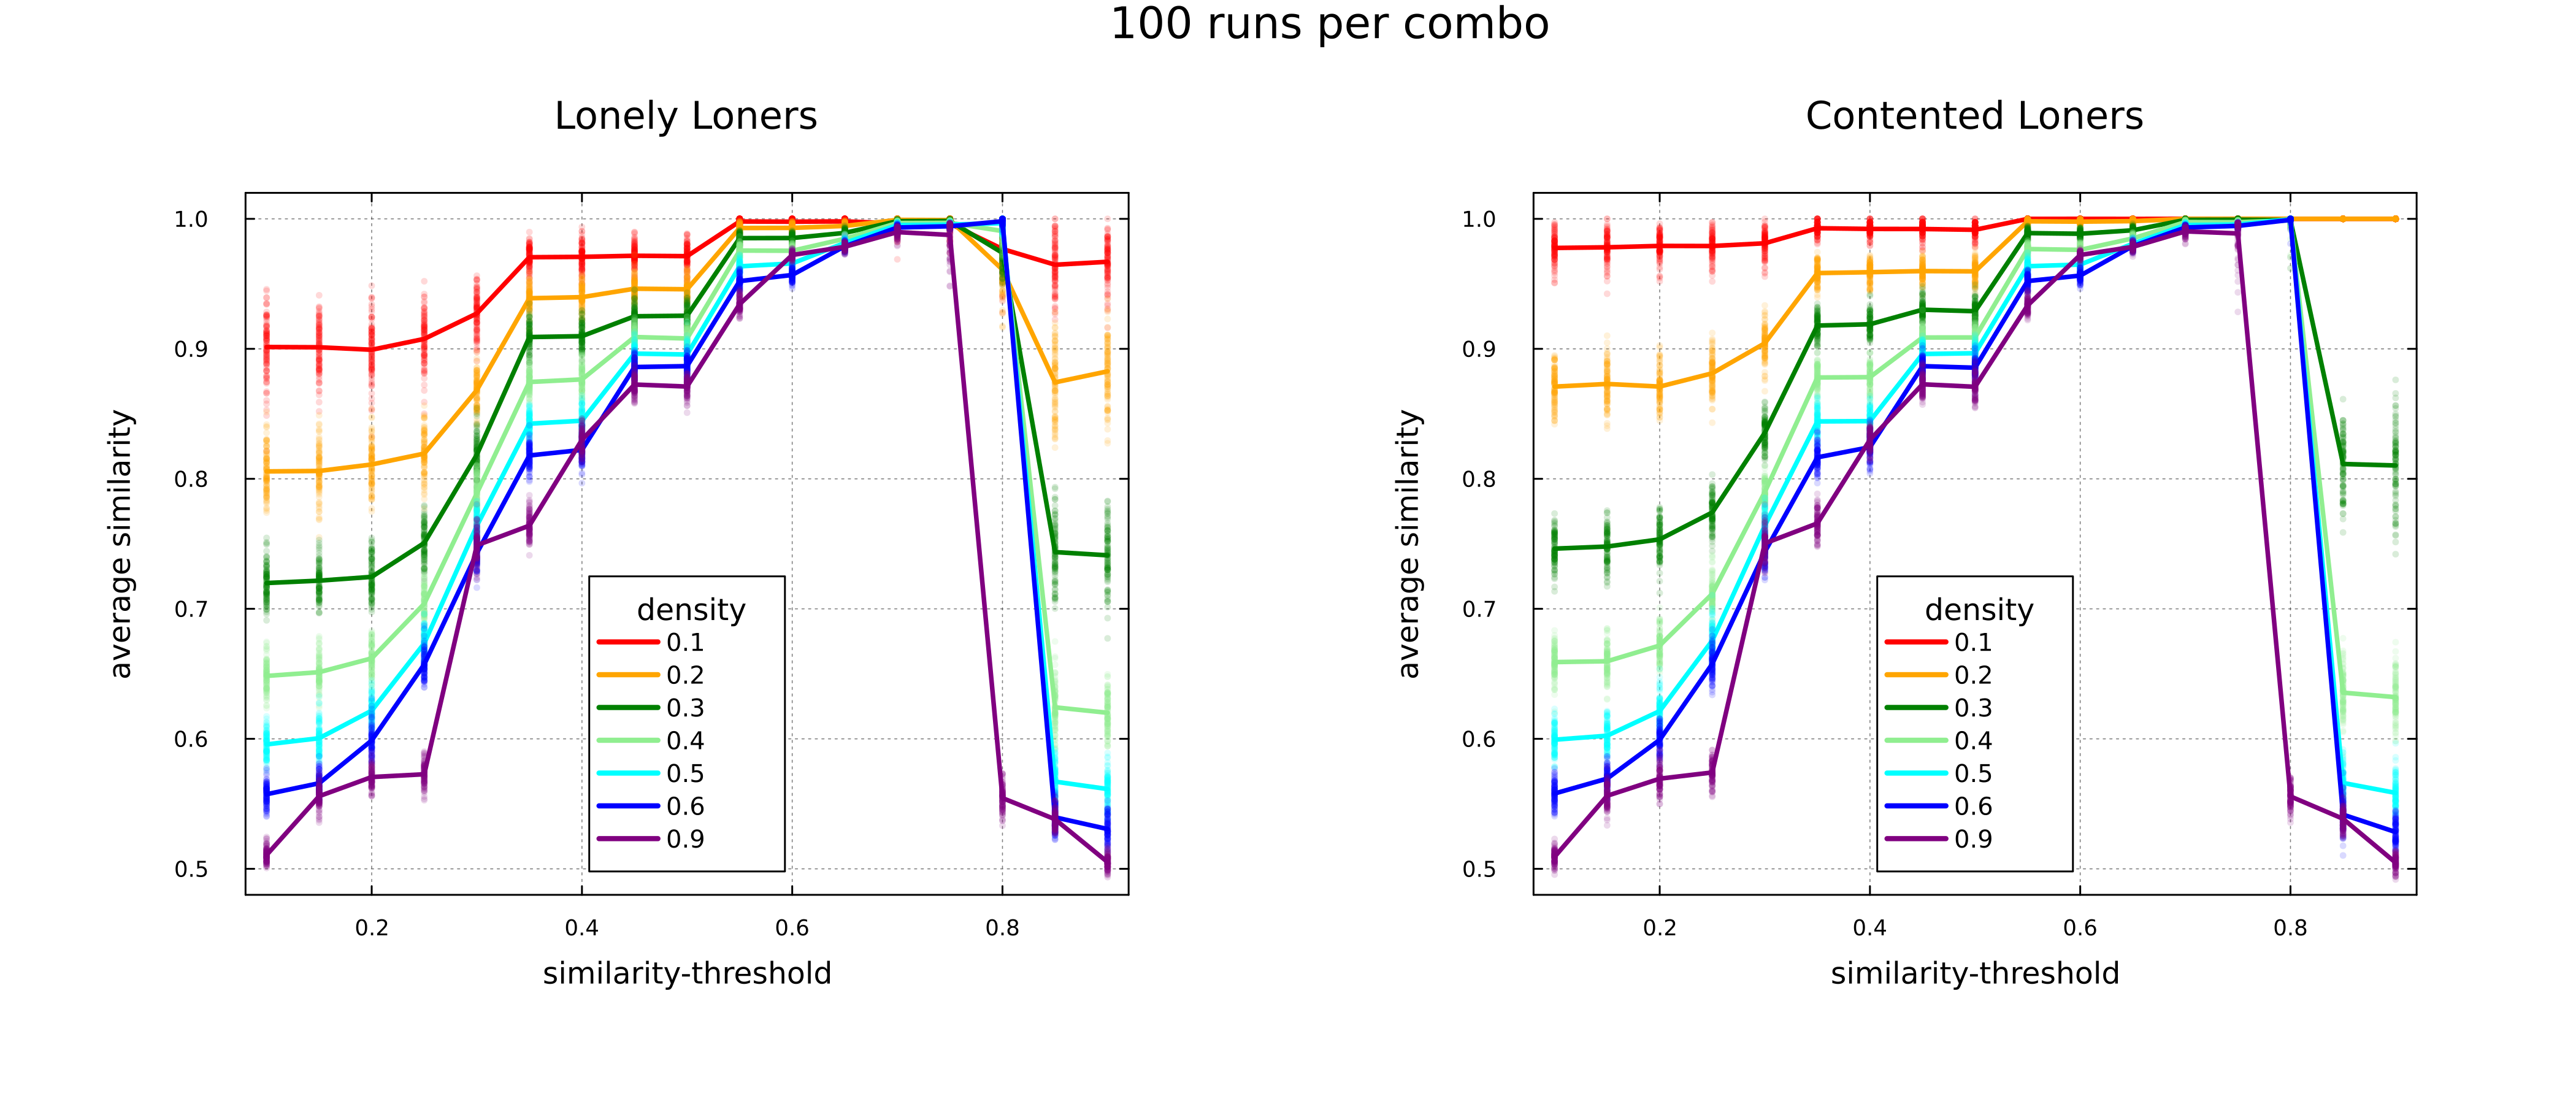

In [24]:
comparison_plots = create_comparison_plots()
display(comparison_plots[1])
display(comparison_plots[2])
display(comparison_plots[3])